<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DL_quest/DL_prep/DL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neutral Network

### 7-1. Structure

**완전연결 신경망**

Data ---> `Affine -> ReLU` ---> `Affine -> ReLU` ---> `Affine -> ReLU` ---> `Affine -> Softmax` ---> L

**CNN**

Data ---> **`Conv -> ReLU -> (Pool)`** ---> `Conv -> ReLU` ---> `Affine -> ReLU` ---> `Affine -> Softmax` ---> L

### 7-2. Convolution layer

* 계층 사이에 3차원 데이터와 같이 입체적인 데이터가 흐른다는 점에서 완전연결 네트워크와 다름.
* 완전연결 시 데이터의 형상이 무시되는 문제를 보완. ex) flatten
* CNN에서 합성곱 계층의 **입출력 데이터**를 `특징 맵 Feature map` 이라 함. 따라서, Input Feature map, Output Feature map.
* 3차원 합성곱 연산에서 입력 데이터의 채널 수와 필터의 채널 수가 같아야 함.

**Padding**

* 합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값(가령, 0)으로 채움.  
* 출력 크기를 조정할 목적으로 사용.  

**Stride**

* 필터를 적용하는 위치의 간격, 보폭.
* 입력 크기를 (H, W), 필터 크기를 (FH, FW), 출력 크기를 (OH, OW), 패딩을 P, 스트라이드를 S 이라고 한다면 수식은 아래와 같음.
* **출력 크기(OH와 OW)는 원소의 개수이니 당연히 정수로 나눌 수 있는 값이어야 함.**

```
OH = (H + 2P - FH / S) + 1
OW = (H + 2P - FW / S) + 1
```

**Convolution Operation**

* CNN에서 계층 사이에 흐르는 데이터는 **4차원**.

```
(DN, C, H, W) * (FN, C, FH, FW) = (DN, FN, OH, OW) + (FN, 1, 1) = 2D.reshape = (DN, FN, OH, OW)
      |                |                                  |                           |
  Input:row      Filter:column                           Bias                      Output
```

### 7-3. Pulling layer

* Pulling은 세로와 가로 방향의 공간을 줄이는 연산.
* 풀링 계층은 합성곱 계층과 달리 학습해야 할 매개변수가 없음.
* 입력 데이터의 채널 수 그대로 출력 데이터를 내보냄.
* 입력 데이터가 조금 변하더라도 풀링 계층의 결과는 잘 변하지 않음.
* 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정하는 것이 보통.

**Max pooling**

* 윈도우에서 가장 큰(값) 원소 하나.
* 이미지 인식 분야에서 주로 사용.

**Average pooling**

* 윈도우의 평균을 계산.

### 7-4. Implement Convolution layer / Pulling layer

* 합성곱 계층과 풀링 계층은 im2col(Image to column, 이미지를 행렬로 전개하는 함수) 함수를 이용하면 간단하고 효율적으로 구현할 수 있음.
* im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는 함수.

In [ ]:
import numpy as np

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) # (DN, C, H, W)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


In [ ]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


In [ ]:
class Convolution:

    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        oh = int(1 + (H + 2 * self.pad - FH) / self.stride)
        ow = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # ========= Convolution Operation =========
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # =========================================
        out = out.reshape(N, oh, ow, -1).transpose(0, 3, 1, 2)

        return out

**out = out.reshape(N, oh, ow, -1).transpose(0, 3, 1, 2)**

* reshape에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 유지됨.
* forward 마지막에 transpose(0, 3, 1, 2)를 사용하여 인덱스로 다차원 배열의 축의 순서를 바꿈.

```
(N, H, W, C) -> (N, C, H, W)
[0, 1, 2, 3] -> [0, 3, 1, 2]
```

**Backward, col2im**

In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


**Convolution layer & Pulling layer**

In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None

        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 1. 입력 데이터를 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)

        # 2. 행 별 최대값 구하기
        out = np.max(col, axis=1)

        # 3. 적절한 모양으로 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

### 7-5. Implement CNN

In [ ]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """

    # SimpleConvNet의 초기화
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # SimpleConvNet의 추론과 손실 함수값 구하기
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.299894096982763
=== epoch:1, train acc:0.173, test acc:0.163 ===
train loss:2.2979371413865417
train loss:2.292904285102211
train loss:2.2889328722429814
train loss:2.278741367116174
train loss:2.2623044563276618
train loss:2.265955879822179
train loss:2.235416564889921
train loss:2.220943561519158
train loss:2.1919015361650502
train loss:2.1861242592712364
train loss:2.136079318474923
train loss:2.083108025766864
train loss:2.032353609143226
train loss:1.9991077378482607
train loss:1.9428504593359137
train loss:1.8397220493575634
train loss:1.7860099996318544
train loss:1.6925236095654832
train loss:1.650197426850948
train loss:1.6543647632441334
train loss:1.4457480761184096
train loss:1.4636820637337433
train loss:1.3978625919349172
train loss:1.2363377355692544
train loss:1.176152080972975
train loss:1.0315099679941224
train loss:1.0464333433090913
train loss:1.0025650348599773
train loss:0.9550478002736265
train loss:0.9859316860893277
train loss:0.7931396055927914
tr

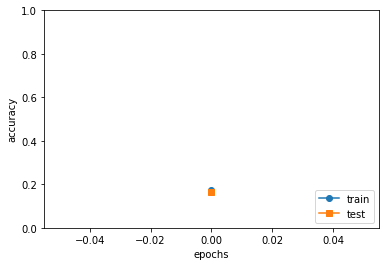

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 1

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 시각화
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 7-6. Visualize CNN

* 합성곱 계층을 여러 겹 쌓으면 층이 깊어지면서 더 복잡하고 추상화 된 정보가 추출.
* 처음 층은 단순한 에지에 반응, 이어서 텍스처에 반응, 더 복잡한 사물에 일부 반응하는 식으로 변화. 즉, 단순한 모양에서 고급 정보로 변화.

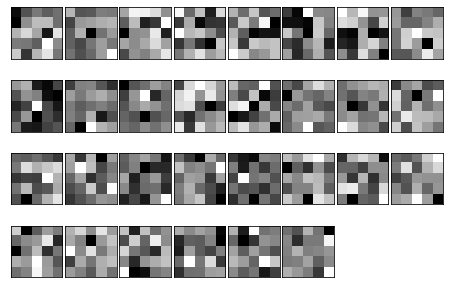

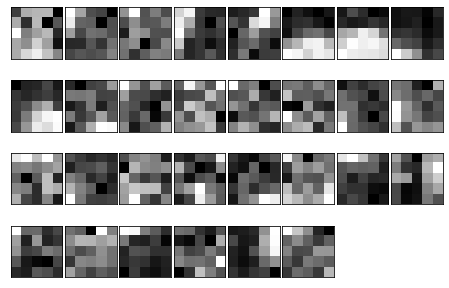

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 7-7. LeNet and AlexNet

**LeNet**

* 손글씨 숫자를 인식하는 네트워크.
* 합성곱 계층과 풀링 계층을 반복하고, 마지막으로 완전연결계층을 거치면서 결과 출력.
* LeNet은 시그모이드 함수를 사용하는 데 반해, 현재의 CNN은 주로 ReLU를 사용.
* LeNet은 서브 샘플링을 하여 중간 데이터의 크기를 줄이지만, 현재의 CNN은 최대 풀링이 주류.

**AlexNet**

* 합성곱 계층과 풀링 계층을 거듭하면서 마지막으로 완전연결계층을 거쳐 결과 출력.
* 활성화 함수로 ReLU 함수를 이용.
* LRN Local Response Nomalization 국소적 정규화를 실시하는 계층을 이용.
* Dropout.